In [1]:
data_path = '/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2'
data_file = '/data/B2/data.mat'
epoch_file = '/data/B2/preprocessing/B2_EEG_epo.fif'

relevant_electrodes = ['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz']

# Dic to index trial_info matrix
info_colnames = {'reaction_times':0,'reaction_err':1, 'answer':2,'base_delay':3,\
                      'target_timings':4, 'flicker_sides':5, 'cued_side':6, 'orients_L':7, 'orients_R':8,\
                      'angle_magnitude':9, 'probe_sides':10, 'targets_binary':12, 'attention_type_block':13,\
                      'trial_num_my_rec':14}
info_colnumtonames = {v: k for k, v in info_colnames.items()}



In [2]:
import scipy.io as sio
import scipy
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import EpochsTFRArray
import matplotlib.pyplot as plt
import copy
from collections import Counter


In [3]:
f = sio.loadmat(f'{data_path}{data_file}')

# Create pd df to pass to mne metadata
pd_info = {}
for i, column in enumerate(f['data'][0][0]):
    if i in info_colnames.values():
        # Remove practice trials
        column = column[4:,:]
        # Collapse to trial indexes
        original_shape = column.shape
        new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
        column = np.reshape(column, new_shape)
        pd_info[info_colnumtonames[i]] = column
pd_info = pd.DataFrame(pd_info, columns=info_colnames.keys())
pd_info 

# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epoch_good = [x for x,y in enumerate(epochs.drop_log) if len(y) == 0]
epochs.metadata = pd_info.iloc[epoch_good]

Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2/data/B2/preprocessing/B2_EEG_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
555 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 14 columns


In [4]:
# Keep only posterior electrodes
epochs.pick_channels(relevant_electrodes)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Number of events,555
Events,3: 555
Time range,-1.000 – 2.000 s
Baseline,-1.000 – 0.000 s


In [5]:
# Keep only trials where there was no target
epochs = epochs['targets_binary==0']

# A. Frequency tagging condition
# 1 - Tag presence
## 1.1 FFT & SNR

In [6]:
epochs_endo = epochs['attention_type_block==1'].copy()

# Simplify metadata
epochs_endo.metadata['flicker_sides'] = epochs_endo.metadata['flicker_sides'].replace({0: 6064, 1: 6460})
epochs_endo.metadata['cued_side'] = epochs_endo.metadata['cued_side'].replace({0: 'left', 1: 'right'})

condition_1 = ((epochs_endo.metadata['flicker_sides'] == 6064.0) & (epochs_endo.metadata['cued_side'] == 'left')) | \
    ((epochs_endo.metadata['flicker_sides'] == 6460.0) & (epochs_endo.metadata['cued_side'] == 'right'))
condition_2 = ((epochs_endo.metadata['flicker_sides'] == 6064.0) & (epochs_endo.metadata['cued_side'] == 'right')) | \
    ((epochs_endo.metadata['flicker_sides'] == 6460.0) & (epochs_endo.metadata['cued_side'] == 'left'))
epochs_endo.metadata['cued_tag'] = np.where(condition_1, 60, np.where(condition_2, 64, np.nan))

SNR at 60Hz: 12.137198530518289
SNR at 64Hz: 11.59807696123856


/tmp/ipykernel_14439/3944468922.py:116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


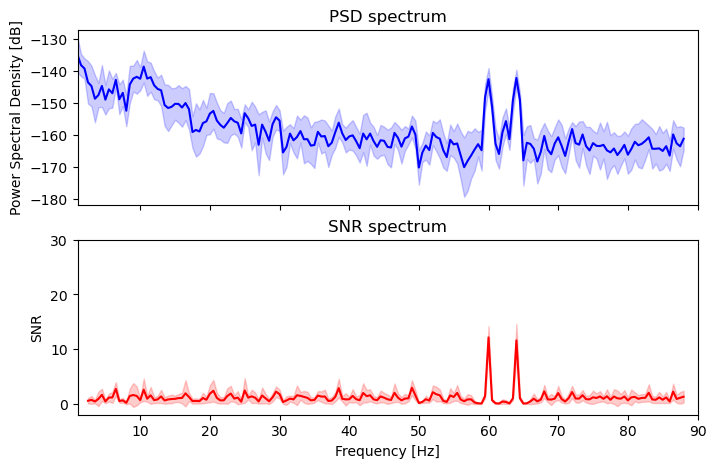

In [7]:
# Fast Fourier Transform
# adapted from https://mne.tools/dev/auto_tutorials/time-freq/50_ssvep.html

sfreq = epochs_endo.info["sfreq"]
tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2
fmin = 1.0
fmax = 90

# Spectrum of the signal averaged over trials
spectrum = epochs_endo.copy().average().compute_psd(
    "welch",
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0,
    n_per_seg=None,
    tmin=tmin,
    tmax=tmax,
    fmin=fmin,
    fmax=fmax,
    window="hamming",
    verbose=False,
)
psds, freqs_psd = spectrum.get_data(return_freqs=True)

# Signal to noise ratio (Meigen & Bach (1999))

def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.
    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate(
        (
            np.ones(noise_n_neighbor_freqs),
            np.zeros(2 * noise_skip_neighbor_freqs + 1),
            np.ones(noise_n_neighbor_freqs),
        )
    )
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode="valid"), axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(mean_noise, pad_width=pad_width, constant_values=np.nan)

    return psd / mean_noise

# Get bins to exlude from regularization (close neighbors ±0.5Hz)  
bin_size = np.diff(freqs_psd)[0]
skip_nei = int((0.5 - bin_size/2)//bin_size) 

# Get bins to include in regularization (neighbors within +/- 2-0.5Hz)
used_nei = int((2 - bin_size/2) // bin_size)  # Total bins within ±2 Hz
used_nei = used_nei - skip_nei # Bins within (0.5 Hz, 2 Hz]


snrs = snr_spectrum(psds, noise_n_neighbor_freqs= used_nei, noise_skip_neighbor_freqs = skip_nei)


%matplotlib inline
fig, axes = plt.subplots(2, 1, sharex="all", sharey="none", figsize=(8, 5))
freq_range = range(
    np.where(np.floor(freqs_psd) == 1.0)[0][0], np.where(np.ceil(freqs_psd) == fmax - 1)[0][0]
)

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0))[freq_range]
psds_std = psds_plot.std(axis=(0))[freq_range]
axes[0].plot(freqs_psd[freq_range], psds_mean, color="b")
axes[0].fill_between(
    freqs_psd[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0].set(title="PSD spectrum", ylabel="Power Spectral Density [dB]")

# SNR spectrum
snr_mean = snrs.mean(axis=(0))[freq_range]
snr_std = snrs.std(axis=(0))[freq_range]

axes[1].plot(freqs_psd[freq_range], snr_mean, color="r")
axes[1].fill_between(
    freqs_psd[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1].set(
    title="SNR spectrum",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 30],
    xlim=[fmin, fmax],
)
fig.show()

# Extract SNR values at the stimulation frequency
stim_freq1 = 60
stim_freq2 = 64

# find index of frequency bin closest to stimulation frequency
i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))

# Apply the subset
snrs_target1 = snrs[:, i_bin_1]
snrs_target2 = snrs[:, i_bin_2]
print(f'SNR at {stim_freq1}Hz: {snrs_target1.mean()}')
print(f'SNR at {stim_freq2}Hz: {snrs_target2.mean()}')


## 1.2 Topography of the SNR

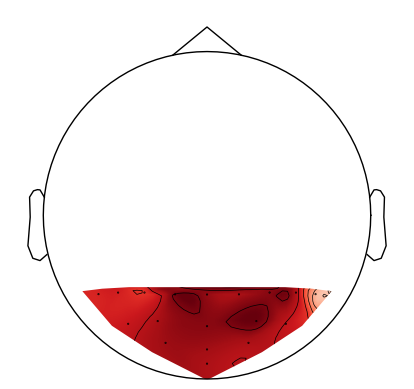

/tmp/ipykernel_14439/3248402069.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


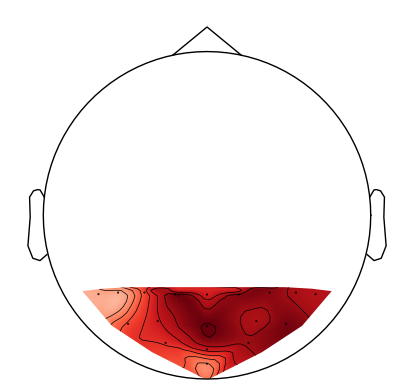

Channels with highest SNR for 60Hz['PO4' 'P1' 'POz' 'P4' 'Pz' 'O1']
Channels with highest SNR for 64Hz['POz' 'P1' 'PO8' 'P2' 'P4' 'O2']


/tmp/ipykernel_14439/3248402069.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [8]:
# plot SNR topography
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_target1, epochs.info, vlim=(1, None), axes=ax, extrapolate='local')
fig.show()
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_target2, epochs.info, vlim=(1, None), axes=ax, extrapolate='local')
fig.show()

# Channels with the highest SNR 
print(f'Channels with highest SNR for 60Hz{np.array(epochs.info['ch_names'])[np.argsort(snrs_target1)[::-1]][:6]}')
print(f'Channels with highest SNR for 64Hz{np.array(epochs.info['ch_names'])[np.argsort(snrs_target2)[::-1]][:6]}')


#select electrodes from 60 as the top electrodes are parietal and occipital
SNR_best_electrodes_60 = np.array(epochs.info['ch_names'])[np.argsort(snrs_target1)[::-1]][:6]
SNR_best_electrodes_64 = np.array(epochs.info['ch_names'])[np.argsort(snrs_target2)[::-1]][:6]

## 1.3 Time frequency analysis of coherence by electrode
Coherence is studied in the time window between trial start and onset of the stimuli (the post stimuli window is likely contaminated by attentional catching due to their onset).

In [9]:
# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1
# Define range of frequencies of interest
freqs = np.arange(55, 75, step = 0.5)

### Magnitude squared coherence with Hilbert transform

Applying baseline correction (mode: mean)
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


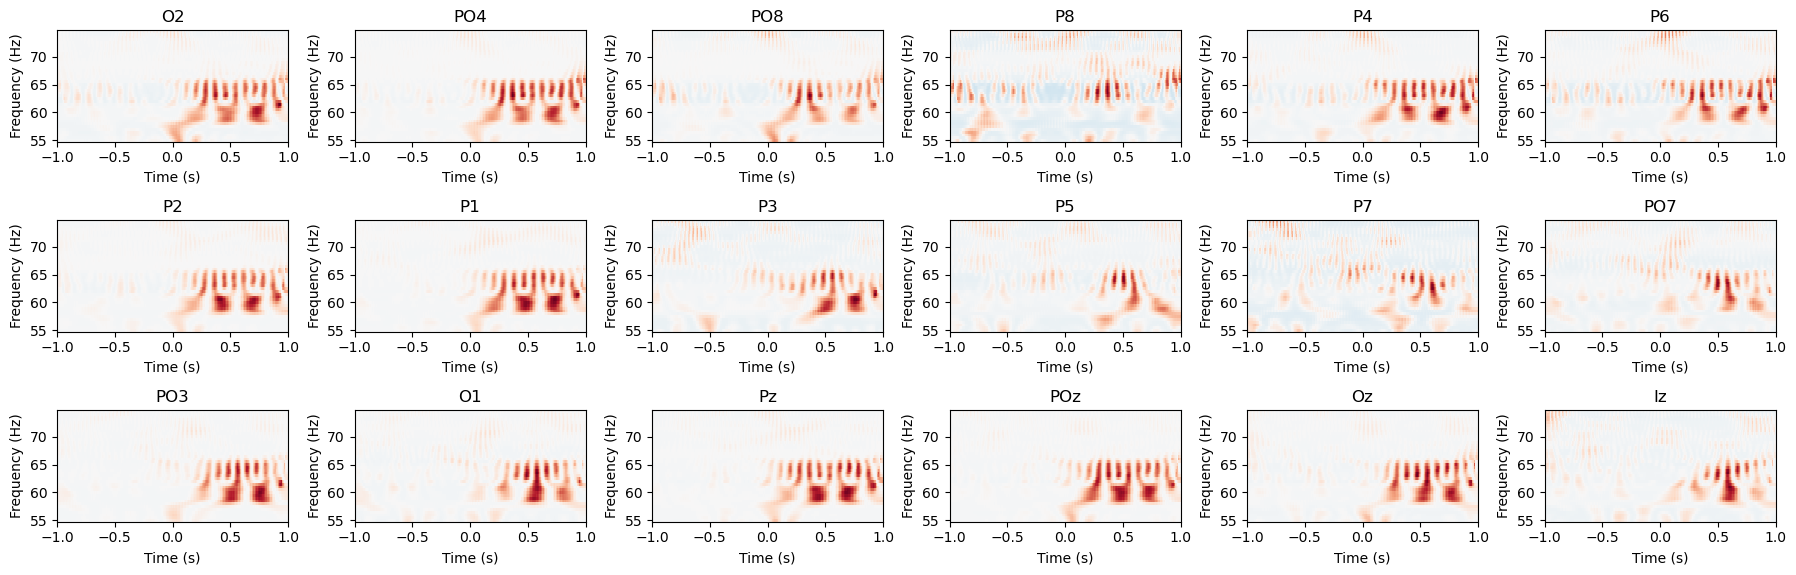

From best to 5th 
Channels with the highest coherence with 60:['POz' 'P2' 'Pz' 'P1' 'PO3' 'PO4']                         
Channels with the highest coherence with 64:['PO4' 'POz' 'Pz' 'PO3' 'P2' 'O1']


In [10]:
def coherence_kabir(signalX, pick, freq_of_interest):

    #get info from EEG
    min_time = signalX.times[0]
    max_time = signalX.times[-1]
    sampling_rate = signalX.info['sfreq']
    
    # Band-pass EEG (+/-1.9Hz) and apply hilbert
    signalX = signalX.copy().pick(pick).filter(l_freq=freq_of_interest - 1.9, h_freq=freq_of_interest + 1.9,
        method='iir', iir_params=dict(order=4, ftype='butter'), phase='zero', fir_window='hamming', verbose = False)
    #filter(l_freq = freq_of_interest - 1.9, h_freq = freq_of_interest + 1.9, verbose=True)
    
    signalX = np.squeeze(signalX.get_data(copy=False)).T
    signalXh =  scipy.signal.hilbert(signalX, axis=1)
    n = signalXh.shape[1]  # number of trials

    #Create sine wave
    t = np.linspace(min_time, max_time, int(sampling_rate * (np.abs(min_time) + max_time))+1, endpoint=False)
    signalY = np.sin(2 * np.pi * freq_of_interest * t)
    signalY = np.tile(signalY, (n,1)).T #repeat over trials
    # Hilbert transform
    signalYh = scipy.signal.hilbert(signalY.T, axis=1)

    # Magnitude
    mX = np.abs(signalXh).T
    mY = np.abs(signalYh)

    # Phase difference
    phase_diff = np.angle(signalXh).T - np.angle(signalYh)

    coh = np.zeros(signalY.shape[0])
    for t in range(signalY.shape[0]):
        num = ((np.abs(np.sum(mX[:, t] * mY[:, t] * np.exp(1j * phase_diff[:, t])) / n)) ** 2)
        denom = (np.sum((mX[:, t]**2) * (mY[:, t]**2)) / n)
        coh[t] = num/denom
        
    return coh

# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1
# Define range of frequencies of interest
freqs = np.arange(55, 75, step = 0.5)

channels = epochs_endo.info['ch_names']

epochs_endo_cropped = epochs_endo.copy().crop(tmin, tmax)

coherence_mat = np.zeros((len(channels), freqs.size, len(epochs_endo_cropped.times)))

for e, channel in enumerate(channels):
    for i, freq in enumerate(freqs):
        coherence_mat[e,i,:] = coherence_kabir(epochs_endo_cropped, [channel], freq)

coherence_hilbert = mne.time_frequency.EpochsTFRArray(epochs_endo_cropped.info, np.array([coherence_mat]), epochs_endo_cropped.times, freqs)

# Baseline (-1 to 0s) correction
coherence_hilbert = coherence_hilbert.apply_baseline(baseline=(tmin, 0))

fig, axes = plt.subplots(3, 6, figsize=(18, 6))  
axes = axes.flatten() 

# Plot each channel
for e, (channel, ax) in enumerate(zip(channels, axes)):
    coherence_hilbert.plot(
        picks=[channel],
        baseline= None,
        axes=ax,
        colorbar=False,
        show=False 
    )
    ax.set_title(channel)  

plt.tight_layout()
plt.show()



# Channels with the highest coherence with the cued frequency
print(f'From best to 5th \nChannels with the highest coherence with 60:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(coherence_mat[:,np.where(freqs == 60),:].max(axis = -1)))[::-1]][:6]} \
                        \nChannels with the highest coherence with 64:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(coherence_mat[:,np.where(freqs == 64),:].max(axis = -1)))[::-1]][:6]}')
best_electrodes_coherence_60 = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(coherence_mat[:,np.where(freqs == 60),:].max(axis = -1)))[::-1]][:6]
best_electrodes_coherence_64 = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(coherence_mat[:,np.where(freqs == 64),:].max(axis = -1)))[::-1]][:6]

### Inter-trial coherence with Morlet estimation

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   21.2s


Applying baseline correction (mode: mean)
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


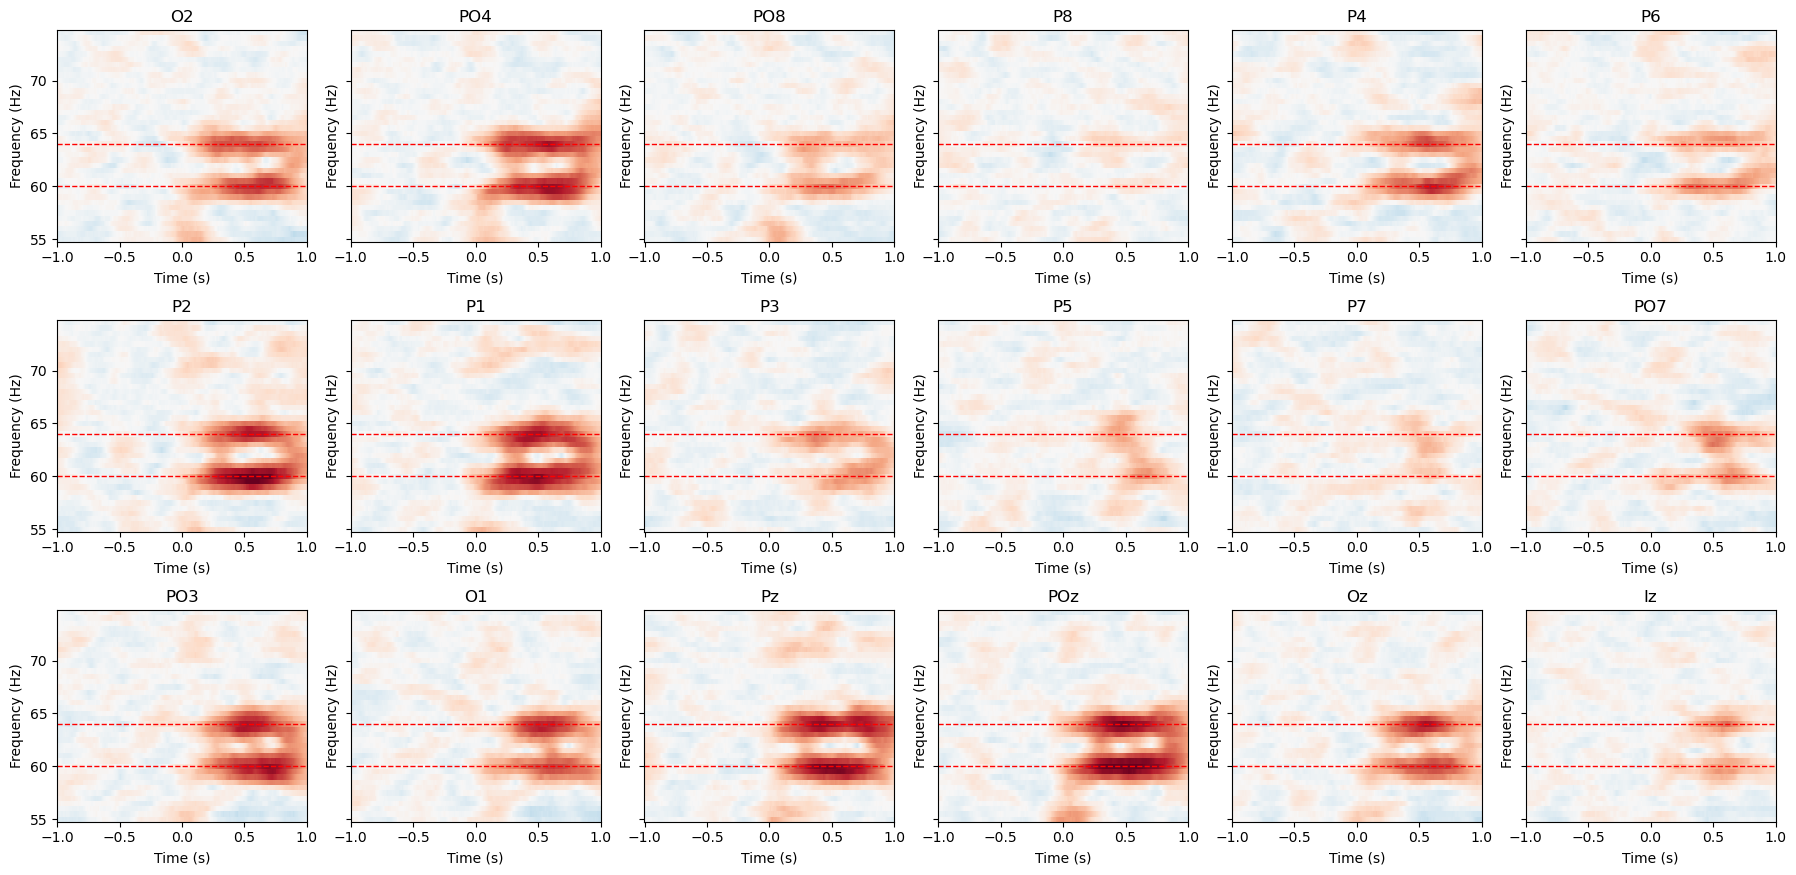

Frequencies with the maximum coherence in descending order : [60.  59.5 64.  60.5]
From best to 6th 
Channels with the highest coherence with 64:['P2' 'POz' 'Pz' 'P1' 'PO3' 'PO4']                         
Channels with the highest coherence with 60:['POz' 'Pz' 'P1' 'PO4' 'Oz' 'PO3']


In [11]:
# n_cylce: trade-off temporal vs frequency resolution (is how many cycles of the frequency to include in the Gaussian envelope). 
# Frequency resolution is emphasized.

# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1
# Define range of frequencies of interest
freqs = np.arange(55, 75, step = 0.5)

_, itc = epochs_endo.copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs, n_cycles=freqs, return_itc=True, average=True
)

# Baseline (-1 to 0s) correction
itc = itc.apply_baseline(baseline=(tmin, 0))

fig, axes = plt.subplots(3, 6, figsize=(18, 9), sharey = True) 
axes = axes.flatten() 

channels = epochs_endo.info['ch_names']

# Plot each electrode
for e, (channel, ax) in enumerate(zip(channels, axes)):
    itc.plot(
        picks=[channel],
        baseline=None,
        vlim=(-.4, .4),
        axes=ax,
        colorbar=False,
        show=False 
    )
    ax.set_title(channel) 
    ax.axhline(y=60, color='r', linestyle='--', linewidth=1)
    ax.axhline(y=64, color='r', linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.show()

# Check whether the expected frequencies are indeed the highest
itc_arr, frex_idx = itc.get_data(return_freqs=True)
print(f'Frequencies with the maximum coherence in descending order : {frex_idx[itc_arr.mean(axis=(0,2)).argsort()[::-1]][:4]}')

print(f'From best to 6th \nChannels with the highest coherence with 64:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]} \
                        \nChannels with the highest coherence with 60:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:6]}')

best_electrodes_coherence_morlet_60 = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]
best_electrodes_coherence_morlet_64 = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:6]

## 1.4 Select electrodes based on previous analysis

In [12]:
print(f'Top 6 electrodes for SNR 60{SNR_best_electrodes_60}')
print(f'Top 6 electrodes for SNR 64{SNR_best_electrodes_64}')
print(f'Top 6 electrodes for Coherence 60 {best_electrodes_coherence_60}')
print(f'Top 6 electrodes for Coherence 64 {best_electrodes_coherence_64}')
print(f'Top 6 electrodes for ITC Morlet 60 {best_electrodes_coherence_morlet_60}')
print(f'Top 6 electrodes for ITC Morlet 64 {best_electrodes_coherence_morlet_64}')

Top 6 electrodes for SNR 60['PO4' 'P1' 'POz' 'P4' 'Pz' 'O1']
Top 6 electrodes for SNR 64['POz' 'P1' 'PO8' 'P2' 'P4' 'O2']
Top 6 electrodes for Coherence 60 ['POz' 'P2' 'Pz' 'P1' 'PO3' 'PO4']
Top 6 electrodes for Coherence 64 ['PO4' 'POz' 'Pz' 'PO3' 'P2' 'O1']
Top 6 electrodes for ITC Morlet 60 ['P2' 'POz' 'Pz' 'P1' 'PO3' 'PO4']
Top 6 electrodes for ITC Morlet 64 ['POz' 'Pz' 'P1' 'PO4' 'Oz' 'PO3']


In [13]:
# Select top 6 electrodes that are the most often the best according to SNR, IT coherence and MS coherence
all_electrodes = (list(SNR_best_electrodes_60) + 
                  list(SNR_best_electrodes_64) + 
                  list(best_electrodes_coherence_60) + 
                  list(best_electrodes_coherence_64) + 
                  list(best_electrodes_coherence_morlet_60) + 
                  list(best_electrodes_coherence_morlet_64))

# Count the occurrences of each electrode
electrode_counts = Counter(all_electrodes)

best_electrodes = [electrode for electrode, count in electrode_counts.most_common(6)]

print(f'selected electrodes: {best_electrodes}')

selected electrodes: ['POz', 'PO4', 'P1', 'Pz', 'P2', 'PO3']


# 2 - Testing for an attentional effect
### Comparing SNR across cued conditions

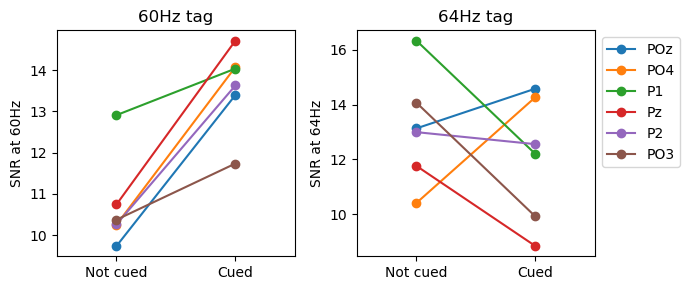

In [14]:
queries = ["cued_tag == 60", "cued_tag == 64"]
vals = {}
stim_freq1 = 60
stim_freq2 = 64

sfreq = epochs_endo.info['sfreq']
tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2
fmin = 1.0
fmax = 90.0

for query in queries:
    # Spectrum averaged over all trials
    spectrum = epochs_endo[query].copy().pick(best_electrodes).average().compute_psd(
        "welch",
        n_fft=int(sfreq * (tmax - tmin)),
        n_overlap=0,
        n_per_seg=None,
        tmin=tmin,
        tmax=tmax,
        fmin=fmin,
        fmax=fmax,
        window="hamming",
        verbose=False,
    )
    psds, freqs_psd = spectrum.get_data(return_freqs=True)

    # Get bins to exlude from regularization (close neighbors ±0.5Hz)  
    bin_size = np.diff(freqs_psd)[0]
    skip_nei = int((0.5 - bin_size/2)//bin_size) 
    
    # Get bins to include in regularization (neighbors within +/- 2-0.5Hz)
    used_nei = int((2 - bin_size/2) // bin_size)  # Total bins within ±2 Hz
    used_nei = used_nei - skip_nei # Bins within (0.5 Hz, 2 Hz]
    
    
    snrs = snr_spectrum(psds, noise_n_neighbor_freqs=used_nei, noise_skip_neighbor_freqs = skip_nei)

    # find index of frequency bin closest to stimulation frequency
    i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
    i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))
    
    # Apply the subset
    vals[str(int(stim_freq1))+query] = copy.deepcopy(snrs[:, i_bin_1])
    vals[str(int(stim_freq2))+query] = copy.deepcopy(snrs[:, i_bin_2])


fig, ax = plt.subplots(1,2, figsize=(7,3), sharex=False)
for e, elec in enumerate(best_electrodes):
    ax[0].plot([0,1], [vals['60cued_tag == 64'][e], vals['60cued_tag == 60'][e]], 'o-', label=elec)
    ax[1].plot([0,1], [vals['64cued_tag == 60'][e], vals['64cued_tag == 64'][e]], 'o-', label=elec)

ax[0].set_ylabel('SNR at 60Hz')
ax[0].set_xticks([0,1], ['Not cued', 'Cued'])
ax[0].set_xlim(-.5, 1.5)
ax[1].set_xlim(-.5, 1.5)
ax[1].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1].set_ylabel('SNR at 64Hz')
ax[0].set_title('60Hz tag')
ax[1].set_title('64Hz tag')
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

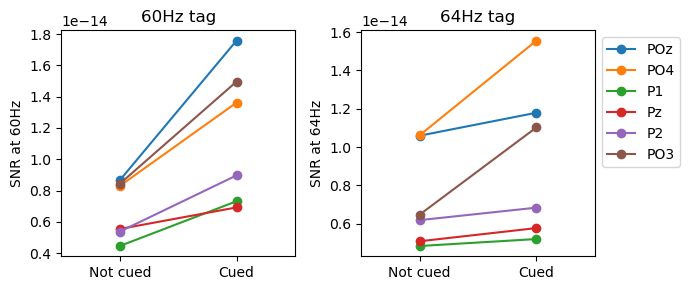

In [15]:
## TEST direct sur PSD ??
queries = ["cued_tag == 60", "cued_tag == 64"]
vals = {}
stim_freq1 = 60
stim_freq2 = 64

sfreq = epochs_endo.info['sfreq']
tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2
fmin = 1.0
fmax = 90.0

for query in queries:
    # Spectrum averaged over all trials
    spectrum = epochs_endo[query].copy().pick(best_electrodes).average().compute_psd(
        "welch",
        n_fft=int(sfreq * (tmax - tmin)),
        n_overlap=0,
        n_per_seg=None,
        tmin=tmin,
        tmax=tmax,
        fmin=fmin,
        fmax=fmax,
        window="hamming",
        verbose=False,
    )
    psds, freqs_psd = spectrum.get_data(return_freqs=True)
    # # Get bins to exlude from regularization (close neighbors ±0.5Hz)  
    # bin_size = np.diff(freqs_psd)[0]
    # skip_nei = int((1 - bin_size/2)//bin_size) 
    
    # # Get bins to include in regularization (neighbors within +/- 2-0.5Hz)
    # used_nei = int((2 - bin_size/2) // bin_size)  # Total bins within ±2 Hz
    # used_nei = used_nei - skip_nei # Bins within (0.5 Hz, 2 Hz]
    
    # snrs = snr_spectrum(psds, noise_n_neighbor_freqs= used_nei, noise_skip_neighbor_freqs = skip_nei)

    # find index of frequency bin closest to stimulation frequency
    i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
    i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))
    
    # Apply the subset
    vals[str(int(stim_freq1))+query] = copy.deepcopy(psds[:, i_bin_1])
    vals[str(int(stim_freq2))+query] = copy.deepcopy(psds[:, i_bin_2])


fig, ax = plt.subplots(1,2, figsize=(7,3), sharex=False)
for e, elec in enumerate(best_electrodes):
    ax[0].plot([0,1], [vals['60cued_tag == 64'][e], vals['60cued_tag == 60'][e]], 'o-', label=elec)
    ax[1].plot([0,1], [vals['64cued_tag == 60'][e], vals['64cued_tag == 64'][e]], 'o-', label=elec)

ax[0].set_ylabel('SNR at 60Hz')
ax[0].set_xticks([0,1], ['Not cued', 'Cued'])
ax[0].set_xlim(-.5, 1.5)
ax[1].set_xlim(-.5, 1.5)
ax[1].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1].set_ylabel('SNR at 64Hz')
ax[0].set_title('60Hz tag')
ax[1].set_title('64Hz tag')
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

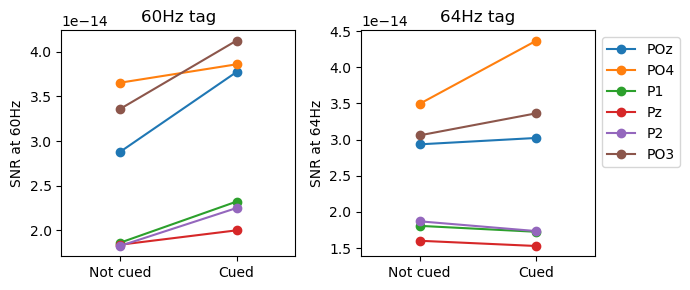

In [22]:
## TEST direct sur PSD ??
queries = ["cued_tag == 60", "cued_tag == 64"]
vals = {}
stim_freq1 = 60
stim_freq2 = 64

sfreq = epochs_endo.info['sfreq']
tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2
fmin = 1.0
fmax = 90.0

for query in queries:
    # Spectrum averaged over all trials
    spectrum = epochs_endo[query].copy().pick(best_electrodes).compute_psd(
        "welch",
        n_fft=int(sfreq * (tmax - tmin)),
        n_overlap=0,
        n_per_seg=None,
        tmin=tmin,
        tmax=tmax,
        fmin=fmin,
        fmax=fmax,
        window="hamming",
        verbose=False,
    )
    psds, freqs_psd = spectrum.get_data(return_freqs=True)
    psds = psds.mean(axis=0)
    # # Get bins to exlude from regularization (close neighbors ±0.5Hz)  
    # bin_size = np.diff(freqs_psd)[0]
    # skip_nei = int((1 - bin_size/2)//bin_size) 
    
    # # Get bins to include in regularization (neighbors within +/- 2-0.5Hz)
    # used_nei = int((2 - bin_size/2) // bin_size)  # Total bins within ±2 Hz
    # used_nei = used_nei - skip_nei # Bins within (0.5 Hz, 2 Hz]
    
    # snrs = snr_spectrum(psds, noise_n_neighbor_freqs= used_nei, noise_skip_neighbor_freqs = skip_nei)

    # find index of frequency bin closest to stimulation frequency
    i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
    i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))
    
    # Apply the subset
    vals[str(int(stim_freq1))+query] = copy.deepcopy(psds[:, i_bin_1])
    vals[str(int(stim_freq2))+query] = copy.deepcopy(psds[:, i_bin_2])


fig, ax = plt.subplots(1,2, figsize=(7,3), sharex=False)
for e, elec in enumerate(best_electrodes):
    ax[0].plot([0,1], [vals['60cued_tag == 64'][e], vals['60cued_tag == 60'][e]], 'o-', label=elec)
    ax[1].plot([0,1], [vals['64cued_tag == 60'][e], vals['64cued_tag == 64'][e]], 'o-', label=elec)

ax[0].set_ylabel('SNR at 60Hz')
ax[0].set_xticks([0,1], ['Not cued', 'Cued'])
ax[0].set_xlim(-.5, 1.5)
ax[1].set_xlim(-.5, 1.5)
ax[1].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1].set_ylabel('SNR at 64Hz')
ax[0].set_title('60Hz tag')
ax[1].set_title('64Hz tag')
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

In [16]:
snr_df = pd.DataFrame(vals)
snr_df['electrode'] = best_electrodes
snr_df = snr_df.melt(id_vars='electrode')
snr_df[['freq', 'cued']] = snr_df['variable'].str.split('cued_tag == ', expand=True)
snr_df = snr_df.drop('variable', axis=1)
snr_df.to_csv('files/B2_snr.csv',index=False)

### Comparing inter-trial coherence across cued conditions

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


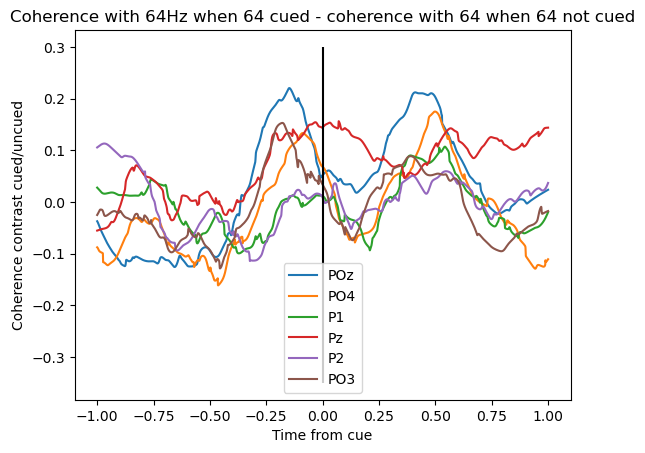

Text(0, 0.5, 'Coherence contrast cued/uncued')

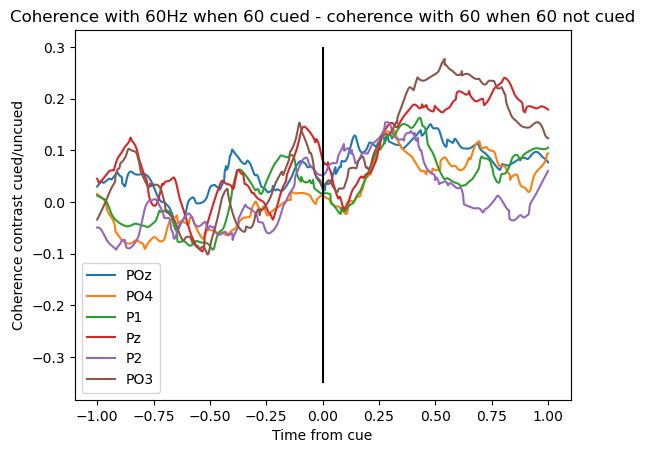

In [17]:
# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1

# Get inter-trial coherence with 60 and 64Hz by cued frequency 
freqs6064 = [60, 64]
_, itc_64 = epochs_endo['cued_tag == 64'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs6064, n_cycles=np.array(freqs6064), return_itc=True, average=True
)

_, itc_60 = epochs_endo['cued_tag == 60'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs6064, n_cycles=np.array(freqs6064), return_itc=True, average=True
)

itc_64_arr, times_coh, freqs_idx = itc_64.get_data(return_freqs = True, return_times = True)
itc_60_arr = itc_60.get_data()

elec_idx = np.where(np.isin(epochs.info['ch_names'], best_electrodes))[0]

coherence = {}
coherence['with64_for64cued'] = itc_64_arr[elec_idx,1,:]
coherence['with60_for64cued'] = itc_64_arr[elec_idx,0,:]
coherence['with64_for60cued'] = itc_60_arr[elec_idx,1,:]
coherence['with60_for60cued'] = itc_60_arr[elec_idx,0,:]

plt.plot(times_coh, coherence['with64_for64cued'].T - coherence['with64_for60cued'].T, label = best_electrodes)
plt.vlines(0,-0.35,0.3, color = 'black')
plt.legend()
plt.title('Coherence with 64Hz when 64 cued - coherence with 64 when 64 not cued')
plt.xlabel('Time from cue')
plt.ylabel('Coherence contrast cued/uncued')
plt.show()

plt.plot(times_coh, coherence['with60_for60cued'].T - coherence['with60_for64cued'].T, label = best_electrodes)
plt.vlines(0,-0.35,0.3, color = 'black')
plt.legend()
plt.title('Coherence with 60Hz when 60 cued - coherence with 60 when 60 not cued')
plt.xlabel('Time from cue')
plt.ylabel('Coherence contrast cued/uncued')

????? il semble qu il n y ait d effet attentionnel. En meme t il ne pouvait pas y avoir de target avant 1s et c etait sur car meme pas les gabor presents.

In [18]:
# Export for group analysis

def pd_coh(coherence_dic, cued, coh_with):
    coherence = pd.DataFrame(coherence_dic[f'with{coh_with}_for{cued}cued'])
    coherence['channel'] = best_electrodes
    coherence['cued'] = cued
    coherence['coh_with'] = coh_with
    coherence = coherence.melt(id_vars=['channel','cued','coh_with'])
    coherence['time'] = coherence['variable']*(1/epochs_endo.info['sfreq']) + tmin
    return coherence

coh64_cue64 = pd_coh(coherence, 64, 64)
coh64_cue60 = pd_coh(coherence, 60, 64)
coh60_cue64 = pd_coh(coherence, 64, 60)
coh60_cue60 = pd_coh(coherence, 60, 60)

ITcoh_B2 = pd.concat([coh60_cue60, coh60_cue64, coh64_cue60, coh64_cue64])
ITcoh_B2.columns = ['channel', 'cued', 'coh_with', 'timepoint', 'ITcoherence', 'time']
ITcoh_B2.to_csv('files/ITcoh_B2.csv',index=False)

### Comparing MS coherence across cued conditions

In [19]:
# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1
# Define range of frequencies of interest
freqs = np.array([60, 64])

epochs_endo_cropped = epochs_endo['cued_tag == 64'].copy().pick(best_electrodes).crop(tmin, tmax)
coherence_mat = np.zeros((len(best_electrodes), freqs.size, len(epochs_endo_cropped.times)))
for e, channel in enumerate(best_electrodes):
    for i, freq in enumerate(freqs):
        coherence_mat[e,i,:] = coherence_kabir(epochs_endo_cropped, [channel], freq)
coherence_hilbert_64 = mne.time_frequency.EpochsTFRArray(epochs_endo_cropped.info, np.array([coherence_mat]), epochs_endo_cropped.times, freqs)

epochs_endo_cropped = epochs_endo['cued_tag == 60'].copy().pick(best_electrodes).crop(tmin, tmax)
coherence_mat = np.zeros((len(best_electrodes), freqs.size, len(epochs_endo_cropped.times)))
for e, channel in enumerate(best_electrodes):
    for i, freq in enumerate(freqs):
        coherence_mat[e,i,:] = coherence_kabir(epochs_endo_cropped, [channel], freq)
coherence_hilbert_60 = mne.time_frequency.EpochsTFRArray(epochs_endo_cropped.info, np.array([coherence_mat]), epochs_endo_cropped.times, freqs)

coherence_hilbert_64, times_coh, freqs_idx = coherence_hilbert_64.get_data(return_freqs = True, return_times = True)
coherence_hilbert_60 = coherence_hilbert_60.get_data()

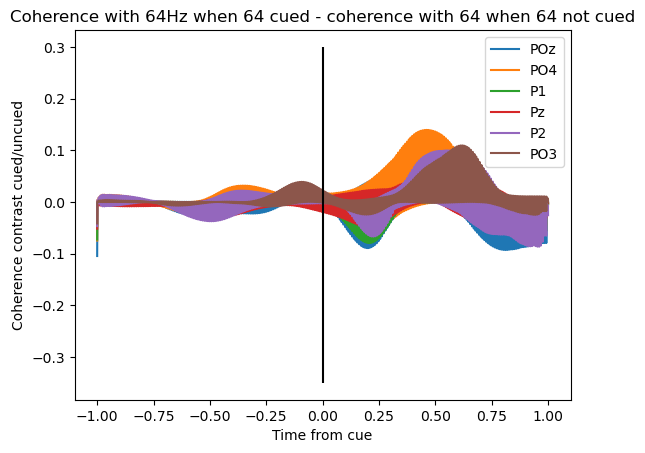

Text(0, 0.5, 'Coherence contrast cued/uncued')

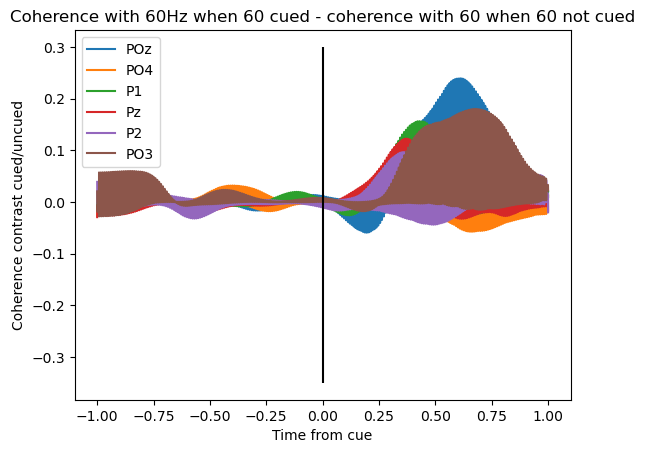

In [20]:
coherence_hilbert = {}
coherence_hilbert['with64_for64cued'] = np.squeeze(coherence_hilbert_64)[:,1,:]
coherence_hilbert['with60_for64cued'] = np.squeeze(coherence_hilbert_64)[:,0,:]
coherence_hilbert['with64_for60cued'] = np.squeeze(coherence_hilbert_60)[:,1,:]
coherence_hilbert['with60_for60cued'] = np.squeeze(coherence_hilbert_60)[:,0,:]

plt.plot(times_coh, coherence_hilbert['with64_for64cued'].T - coherence_hilbert['with64_for60cued'].T, label = best_electrodes)
plt.vlines(0,-0.35,0.3, color = 'black')
plt.legend()
plt.title('Coherence with 64Hz when 64 cued - coherence with 64 when 64 not cued')
plt.xlabel('Time from cue')
plt.ylabel('Coherence contrast cued/uncued')
plt.show()

plt.plot(times_coh, coherence_hilbert['with60_for60cued'].T - coherence_hilbert['with60_for64cued'].T, label = best_electrodes)
plt.vlines(0,-0.35,0.3, color = 'black')
plt.legend()
plt.title('Coherence with 60Hz when 60 cued - coherence with 60 when 60 not cued')
plt.xlabel('Time from cue')
plt.ylabel('Coherence contrast cued/uncued')

In [21]:
# Export for group analysis
coh64_cue64 = pd_coh(coherence_hilbert, 64, 64)
coh64_cue60 = pd_coh(coherence_hilbert, 60, 64)
coh60_cue64 = pd_coh(coherence_hilbert, 64, 60)
coh60_cue60 = pd_coh(coherence_hilbert, 60, 60)

MScoh_B2 = pd.concat([coh60_cue60, coh60_cue64, coh64_cue60, coh64_cue64])
MScoh_B2.columns = ['channel', 'cued', 'coh_with', 'timepoint', 'MScoherence', 'time']
MScoh_B2.to_csv('files/MScoh_B2.csv',index=False)